   *«Покупатель бывает ужасен, но если ему сказать об этом, он станет еще ужасней.»*

   -- Афоризм о продажах

# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов. Данное нововведение поможет:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

В данной работе построим модель, которая по фотографии определит приблизительный возраст человека.

## Исследовательский анализ данных

In [2]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

Загрузим фотографии из подготовленного датасета.

In [3]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


train = load_train('/datasets/faces/')
test = load_test('/datasets/faces/')

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [4]:
train[0][0].shape

(16, 224, 224, 3)

График распределения возраста людей на фотографиях выглядит следующим образом:

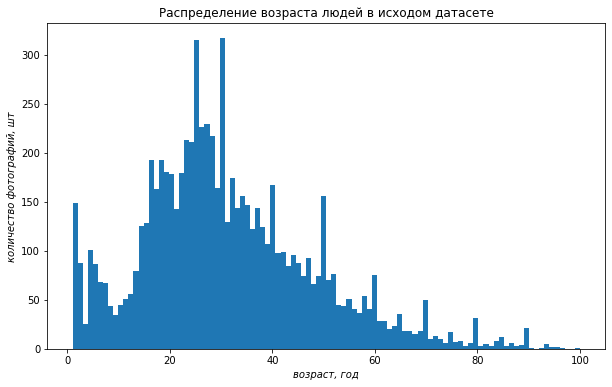

In [5]:
df = pd.read_csv('/datasets/faces/labels.csv')

df['real_age'].hist(bins=100, grid=False, figsize=(10,6))
plt.title('Распределение возраста людей в исходом датасете')
plt.ylabel('количество фотографий, шт', style='italic')
plt.xlabel('возраст, год', style='italic');

Можно посмотреть на некоторые фотографии людей в датасете, при этом можно заметить, что фотографии в тестовой и тренировочной выборках отличаются:

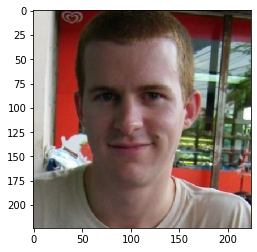

In [6]:
plt.imshow(train[0][0][0])

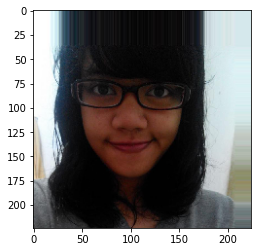

In [7]:
plt.imshow(test[0][0][0])

В указанных данным можно найти фотографии детей и взрослых людей.

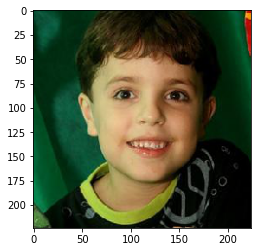

In [8]:
plt.imshow(train[0][0][9])

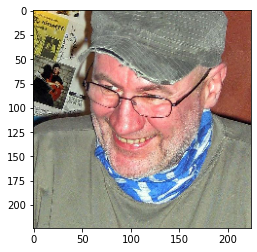

In [9]:
plt.imshow(train[0][0][8])

Можно заметить, что некоторые фотографии имеют некоторую дополнительную обработку, связанную с наличием вращения, изменения масштаба.

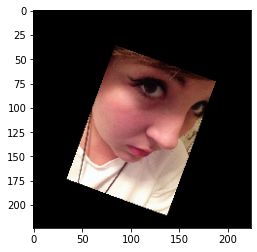

In [21]:
plt.imshow(train[0][0][1])

В датасете присутвсуют фотографии различного разрешения.

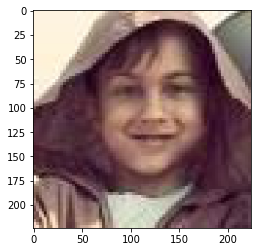

In [11]:
plt.imshow(train[0][0][3])

Кроме того, можем посмотреть на загружаемые данные. В приведённых данных нет пропусков и отсутсвуют дубликаты в именах файлов, что гарантирует то, что один файл не будет использован дважды при обучении.

In [9]:
df.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [15]:
df['file_name'].duplicated().sum()

0

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Датасет содержит 7591 различных файлов для анализа, что является достаточным объёмом для решения поставленной задачи.

Данные содержат информацию о людях разных возрастов, распределение которого имеет пуассоновский вид в общем с некоторыми локальными пиками в частности. Данные пики появляются из-за наличия большого количества праздничных фотографий. Большинство фотоматериалов относятся к людям, возраст которых находится в промежутке между 17 и 35 годами. Также имеется некоторый пик количества фотографий для людей с возрастом вблизи нуля. Изучить распределение возраста важно, поскольку этот показатель является целевым для нашего исследования.

Кроме того в данных присутсвуют фотографии людей, различающихся, по полу, рассе, демонстрируемой эмоции. Данные фотографии сделаны с различных ракурсов и для людей в разной одежде. Также фотографии по-разному обработаны и имеют разное разрешение (в рамках данного исследования все фотографии приводятся к одному разрешению (224x224)). Всё это может значить, что модель будет хорошо распознавать возраст не только один у одной категории лиц, но у людей вообще.

## Обучение модели

Обучим модель распозновать возраст людей на фотографиях, запустив код ниже локальными методами на спец-компьютере, использующем GPU.

```python
optimizer = Adam(lr=0.0001)

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
#    model.add(Dense(units=10, activation='softmax'))
 
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mae'])
 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=6,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model 
```

Получим следующий вывод по результатам выполнения функций, расположенных выше:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/6
356/356 - 66s - loss: 10.8704 - mae: 10.8662 - val_loss: 14.4829 - val_mae: 14.4771
Epoch 2/6
356/356 - 45s - loss: 7.5171 - mae: 7.5169 - val_loss: 10.8650 - val_mae: 10.8589
Epoch 3/6
356/356 - 40s - loss: 6.5568 - mae: 6.5563 - val_loss: 7.2559 - val_mae: 7.2585
Epoch 4/6
356/356 - 44s - loss: 5.9205 - mae: 5.9211 - val_loss: 6.6285 - val_mae: 6.6380
Epoch 5/6
356/356 - 44s - loss: 5.3515 - mae: 5.3518 - val_loss: 7.0720 - val_mae: 7.0682
Epoch 6/6
356/356 - 44s - loss: 4.9076 - mae: 4.9079 - val_loss: 6.8309 - val_mae: 6.8291

119/119 - 10s - loss: 6.8309 - mae: 6.8291
Test MAE: 6.8291
```

## Анализ обученной модели

В ходе исследования в рамках данного проекта была получена модель, способная распознать возраст людей на фотографиях. MAE данной модели составил ~6.41, что является достаточным для успешного внедрения данной разработки в систему компьютерного зрения магазина "Хлеб-Соль".